# Train Log 20181129

## Results
```

```

## Trained model
* [Download link]()

## Evaluation
* Incorrect sample
![results]()

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import time , datetime

sys.path.append( os.path.abspath('../../../Dataset/scripts'))
from utils import *

sys.path.append( os.path.abspath('../../model') )
from train import *
import model_opt5 as MODEL

In [2]:
""" Path """
data_train_path = os.path.abspath('../../../Dataset_ver2/dataset/db_v8_aug_20181129_ndb_v2_20181020/train.h5')
data_vali_path = os.path.abspath('../../../Dataset_ver2/dataset/db_v8_aug_20181129_ndb_v2_20181020/vali.h5')

log_path = os.path.abspath('./train_log_20181129.txt')

model_save_path = os.path.abspath('./model')
if not os.path.isdir(model_save_path) : os.mkdir(model_save_path)

""" Parameters """
GPU_INDEX = 0
NUM_POINT = 1024
NUM_CLASSES = 5

BN_INIT_DECAY = 0.5
BN_DECAY_DECAY_RATE = 0.5
BN_DECAY_DECAY_STEP = float(200000)
BN_DECAY_CLIP = 0.99
DECAY_STEP = BN_DECAY_DECAY_STEP
DECAY_RATE = BN_DECAY_DECAY_RATE

BATCH_SIZE = 250

MOMENTUM = 0.9

BASE_LEARNING_RATE = 0.001

OPTIMIZER = 'adam'

MAX_EPOCH = 10

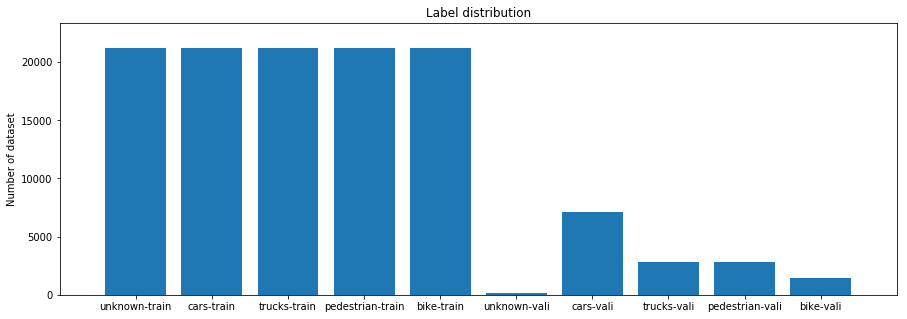

In [3]:
""" Load dataset"""

data = []
label = []

data_train, label_train = load_h5(data_train_path)
data_vali, label_vali = load_h5(data_vali_path)

data.append(data_train)
data.append(data_vali)
label.append(label_train)
label.append(label_vali)

""" Data statistics """

label_list = [0,1,2,3,4]

y_val = []
for i in range( len ( data) ):
    for j in range ( len ( label_list ) ):
        y_val.append(np.sum(label[i] == label_list[j]))

x_name=('unknown-train', 'cars-train', 'trucks-train', 'pedestrian-train', 'bike-train',
        'unknown-vali', 'cars-vali', 'trucks-vali', 'pedestrian-vali', 'bike-vali')

index = range( len(x_name) )

plt.figure(figsize=(15,5))
plt.bar(index, y_val, tick_label=x_name, align='center')
plt.ylabel('Number of dataset')
plt.title('Label distribution')
plt.xlim( -1, len(x_name))
plt.ylim( 0, np.max(y_val) * 1.1 )
plt.show()

In [6]:
""" log file """
LOG_FOUT = open(log_path, 'w')

def log_string(out_str):
    out_str = str( datetime.datetime.fromtimestamp( time.time() ) ) + "  " + out_str
    LOG_FOUT.write(out_str+'\n')
    LOG_FOUT.flush()
    print(out_str)
    
    
def get_learning_rate(batch):
    learning_rate = tf.train.exponential_decay(
                        BASE_LEARNING_RATE,  # Base learning rate.
                        batch * BATCH_SIZE,  # Current index into the dataset.
                        DECAY_STEP,          # Decay step.
                        DECAY_RATE,          # Decay rate.
                        staircase=True)
    learning_rate = tf.maximum(learning_rate, 0.00001) # CLIP THE LEARNING RATE!
    return learning_rate        

def get_bn_decay(batch):
    bn_momentum = tf.train.exponential_decay(
                      BN_INIT_DECAY,
                      batch * BATCH_SIZE,
                      BN_DECAY_DECAY_STEP,
                      BN_DECAY_DECAY_RATE,
                      staircase=True)
    bn_decay = tf.minimum(BN_DECAY_CLIP, 1 - bn_momentum)
    return bn_decay

""" load traing model """
with tf.Graph().as_default():
    with tf.device('/gpu:'+str(GPU_INDEX)):
        pointclouds_pl, labels_pl = MODEL.placeholder_inputs(BATCH_SIZE, NUM_POINT)
        is_training_pl = tf.placeholder(tf.bool, shape=())
        print(is_training_pl)

        # Note the global_step=batch parameter to minimize. 
        # That tells the optimizer to helpfully increment the 'batch' parameter for you every time it trains.
        batch = tf.Variable(0)
        bn_decay = get_bn_decay(batch)
        tf.summary.scalar('bn_decay', bn_decay)

        # Get model and loss 
        pred, end_points = MODEL.get_model(pointclouds_pl, is_training_pl, bn_decay=bn_decay)
        loss = MODEL.get_loss(pred, labels_pl, end_points)
        tf.summary.scalar('loss', loss)

        correct = tf.equal(tf.argmax(pred, 1), tf.to_int64(labels_pl))
        accuracy = tf.reduce_sum(tf.cast(correct, tf.float32)) / float(BATCH_SIZE)
        tf.summary.scalar('accuracy', accuracy)

        # Get training operator
        learning_rate = get_learning_rate(batch)
        tf.summary.scalar('learning_rate', learning_rate)
        if OPTIMIZER == 'momentum':
            optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=MOMENTUM)
        elif OPTIMIZER == 'adam':
            optimizer = tf.train.AdamOptimizer(learning_rate)
        train_op = optimizer.minimize(loss, global_step=batch)

        # Add ops to save and restore all the variables.
        saver = tf.train.Saver()

    # Create a session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.allow_soft_placement = True
    config.log_device_placement = False
    sess = tf.Session(config=config)

    # Add summary writers
    #merged = tf.merge_all_summaries()
    merged = tf.summary.merge_all()

    train_writer_path = os.path.abspath('./train')
    if os.path.isdir(train_writer_path): os.system('rm -r {}'.format(train_writer_path))
    os.mkdir(train_writer_path)
        
    test_writer_path = os.path.abspath('./test')
    if os.path.isdir(test_writer_path): os.system('rm -r {}'.format(test_writer_path))
    os.mkdir(test_writer_path)
    
    
    train_writer = tf.summary.FileWriter(train_writer_path, sess.graph)
    test_writer = tf.summary.FileWriter(test_writer_path)
    
    
    # Init variables
    init = tf.global_variables_initializer()
    # To fix the bug introduced in TF 0.12.1 as in
    # http://stackoverflow.com/questions/41543774/invalidargumenterror-for-tensor-bool-tensorflow-0-12-1
    #sess.run(init)
    sess.run(init, {is_training_pl: True})

    ops = {'pointclouds_pl': pointclouds_pl,
           'labels_pl': labels_pl,
           'is_training_pl': is_training_pl,
           'pred': pred,
           'loss': loss,
           'train_op': train_op,
           'merged': merged,
           'step': batch}
    
            
    for epoch in range(MAX_EPOCH):
        
        ## Training
        log_string ( " Train one epoch %3d / %3d" % (epoch+1, MAX_EPOCH) )
        sys.stdout.flush()
        
        is_training = True
        
        # Shuffle train files
        train_file_idxs = np.arange(0, data_train.shape[0])
        np.random.shuffle(train_file_idxs)
        
        current_data = data_train[train_file_idxs] 
        current_label = label_train[train_file_idxs]
        current_label.reshape((data_train.shape[0],))
              
        ## Evaluation metric
        total_correct = 0
        total_seen = 0
        loss_sum = 0
        
        total_class = [0 for _ in range(NUM_CLASSES)]
        total_detect_class = [0 for _ in range(NUM_CLASSES)]
        total_correct_class = [0 for _ in range(NUM_CLASSES)]
            
        num_batches = current_data.shape[0] // BATCH_SIZE
               
        for batch_idx in trange(num_batches):
            
            start_idx = batch_idx * BATCH_SIZE
            end_idx = (batch_idx+1) * BATCH_SIZE           

            # Augment batched point clouds by rotation and jittering
            rotated_data = provider.rotate_point_cloud(current_data[start_idx:end_idx, :, :])
            jittered_data = provider.jitter_point_cloud(rotated_data)
            
            feed_dict = {ops['pointclouds_pl']: jittered_data,
                         ops['labels_pl']: current_label[start_idx:end_idx].reshape((BATCH_SIZE,)),
                         ops['is_training_pl']: is_training,}
            
            summary, step, _, loss_val, pred_val = sess.run([ops['merged'], ops['step'],
                ops['train_op'], ops['loss'], ops['pred']], feed_dict=feed_dict)
            
            train_writer.add_summary(summary, step)
            
            pred_val = np.argmax(pred_val, 1)
            correct = np.sum(pred_val == current_label[start_idx:end_idx])
            total_correct += correct
            total_seen += BATCH_SIZE
            loss_sum += loss_val
            
            for i in range(NUM_CLASSES):
                total_class[i] = np.sum( np.ones(BATCH_SIZE) * i == current_label[start_idx:end_idx] )
                total_detect_class[i] = np.sum( np.ones(BATCH_SIZE) * i == pred_val )
                total_correct_class[i] = np.sum( (np.ones(BATCH_SIZE) * i == current_label[start_idx:end_idx]) * \
                                                    (np.ones(BATCH_SIZE) * i == pred_val) )
                                
        log_string(  '[Epoch %d] mean loss: %f' % \
                   (  epoch, loss_sum / float(total_seen)  )   )
        log_string(  '[Epoch %d] accuracy: %f'% \
                   (  epoch, total_correct / float(total_seen)  )   )
        log_string(  '[Epoch %d] avg class acc: %f' % \
                   (  epoch, np.mean( np.array(total_correct_class)/np.array(total_class,dtype=np.float) )  )   )
        
        for i_cls in range(NUM_CLASSES):
            if not float(total_class[i_cls]) == 0:
                log_string(  '[Epoch %d] indivisual [%d] class recall: %f' % \
                       (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_class[i_cls])))    
            if not float(total_detect_class[i_cls]) == 0:
                log_string(  '[Epoch %d] indivisual [%d] class precision: %f' % \
                       (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_detect_class[i_cls])))    


        ## Evaluation using validation set    
        log_string ( " Evaluation one (validation set) epoch %3d / %3d" % (epoch+1, MAX_EPOCH) )
        sys.stdout.flush()
        
        is_training = False
        total_correct = 0
        total_seen = 0
        total_seen_class = [0 for _ in range(NUM_CLASSES)]
        total_correct_class = [0 for _ in range(NUM_CLASSES)]
        total_detect_class = [0 for _ in range(NUM_CLASSES)]
        total_detect_true_class = [0 for _ in range(NUM_CLASSES)]
        
        # Shuffle validation files
        file_idxs = np.arange(0, data_vali.shape[0])
        np.random.shuffle(file_idxs)
        
        current_data = data_vali[file_idxs]
        current_label = label_vali[file_idxs]
        
        num_batches = current_data.shape[0] // BATCH_SIZE
               
        for batch_idx in trange(num_batches):
            start_idx = batch_idx * BATCH_SIZE
            end_idx = (batch_idx+1) * BATCH_SIZE

            feed_dict = {ops['pointclouds_pl']: current_data[start_idx:end_idx, :, :],
                         ops['labels_pl']: current_label[start_idx:end_idx].reshape( (BATCH_SIZE,) ),
                         ops['is_training_pl']: is_training}
            summary, step, loss_val, pred_val = sess.run([ops['merged'], ops['step'],
                ops['loss'], ops['pred']], feed_dict=feed_dict)
            
            # test_writer.add_summary(summary, step)
            
            pred_val = np.argmax(pred_val, 1)
            correct = np.sum(pred_val == current_label[start_idx:end_idx])
            total_correct += correct
            total_seen += BATCH_SIZE
            
            for i in range(NUM_CLASSES):
                total_class[i] = np.sum( np.ones(BATCH_SIZE) * i == current_label[start_idx:end_idx] )
                total_detect_class[i] = np.sum( np.ones(BATCH_SIZE) * i == pred_val )
                total_correct_class[i] = np.sum( (np.ones(BATCH_SIZE) * i == current_label[start_idx:end_idx]) * \
                                                    (np.ones(BATCH_SIZE) * i == pred_val) )
                                
        log_string(  '[Epoch %d] vali mean loss: %f' % \
                   (  epoch, loss_sum / float(total_seen)  )   )
        log_string(  '[Epoch %d] vali accuracy: %f'% \
                   (  epoch, total_correct / float(total_seen)  )   )
        log_string(  '[Epoch %d] vali avg class acc: %f' % \
                   (  epoch, np.mean( np.array(total_correct_class) / np.array(total_class) )  )   )
        
        for i_cls in range(NUM_CLASSES):
            log_string(  '[Epoch %d] vali indivisual [%d] class recall: %f' % \
                       (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_class[i_cls])))    
            log_string(  '[Epoch %d] vali indivisual [%d] class precision: %f' % \
                       (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_detect_class[i_cls])))    
             
 
        # Save the variables to disk.
        if ( epoch + 1 ) % 10 == 0:
            save_path = saver.save(sess, os.path.join(model_save_path, "model.ckpt"))
            log_string("Model saved in file: %s" % save_path)
                

Tensor("Placeholder_2:0", shape=(), dtype=bool, device=/device:GPU:0)
INFO:tensorflow:Summary name classify loss is illegal; using classify_loss instead.
INFO:tensorflow:Summary name mat loss is illegal; using mat_loss instead.
2018-11-29 23:50:44.887371   Train one epoch   1 /  10
2018-11-29 23:50:45.387344   Evaluation one (validation set) epoch   1 /  10


100%|██████████| 57/57 [01:34<00:00,  1.66s/it]

2018-11-29 23:52:20.332106  [Epoch 0] vali mean loss: 0.000000
2018-11-29 23:52:20.332549  [Epoch 0] vali accuracy: 49.333333
2018-11-29 23:52:20.332913  [Epoch 0] vali avg class acc: 0.200000
2018-11-29 23:52:20.333077  [Epoch 0] vali indivisual [0] class recall: 0.000000


ZeroDivisionError: float division by zero